# Tutorial 2: Galaxy Catalogue Generation with GalSBI

## Introduction

In this tutorial, you'll learn how to generate realistic galaxy catalogues using **GalSBI** (Galaxy Survey Builder Interface). This is a crucial step because realistic catalogues contain the complexity and correlations found in real astronomical surveys.

### What is GalSBI?

GalSBI is a tool that generates mock galaxy catalogues based on survey characteristics and cosmological models. It provides:

- **Realistic galaxy distributions** on the sky
- **Physical properties** (magnitudes, sizes, redshifts)
- **Survey-specific effects** (selection functions, masks)
- **Consistent cosmological framework**

### Learning Objectives

By the end of this tutorial, you will:
1. Understand how to set up GalSBI for catalogue generation
2. Work with survey masks and sky coverage
3. Generate galaxy catalogues with realistic properties
4. Understand the structure of generated catalogues
5. Visualize galaxy distributions on the sky

### Prerequisites

- Completion of Tutorial 1 (Basic Concepts)
- Understanding of HEALPix maps
- Basic knowledge of astronomical surveys

In [1]:
# Import required packages
print('🚀 Starting Galaxy Catalogue Generation Tutorial')

try:
    from galsbi import GalSBI
    print('✅ GalSBI imported successfully')
except ImportError:
    print('❌ GalSBI not found. Please install: pip install galsbi')
    print('📝 For this tutorial, we\'ll work with pre-generated data')

import matplotlib.pyplot as plt
import healpy as hp
import numpy as np
import time
from pathlib import Path

# Set up plotting
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

print('📦 All packages imported')

🚀 Starting Galaxy Catalogue Generation Tutorial
✅ GalSBI imported successfully
📦 All packages imported


## Part 1: Understanding Survey Masks

Real astronomical surveys don't cover the entire sky uniformly. They have:
- **Masked regions**: Areas not observed (bright stars, bad weather, etc.)
- **Varying depth**: Different exposure times in different regions
- **Geometric constraints**: Telescope pointing limitations

Survey masks are HEALPix maps where:
- `mask[pixel] = 1`: Observed region
- `mask[pixel] = 0`: Masked (not observed) region

### Creating a Simple Circular Mask

Let's create a circular survey mask covering approximately 1000 square degrees:

In [2]:
# Create a circular survey mask
nside_mask = 256
npix = hp.nside2npix(nside_mask)

# Survey parameters
survey_center_ra = 45.0   # degrees
survey_center_dec = 89.0  # degrees (near north pole for simplicity)
survey_radius = 17.8      # degrees (for ~1000 sq deg)

print(f"Creating circular survey mask:")
print(f"  Center: RA={survey_center_ra}°, Dec={survey_center_dec}°")
print(f"  Radius: {survey_radius}°")
print(f"  Expected area: ~{np.pi * survey_radius**2:.0f} sq deg")

# Create the mask
mask = np.zeros(npix)

# Get pixel coordinates
theta, phi = hp.pix2ang(nside_mask, np.arange(npix), lonlat=True)
ra_pix, dec_pix = theta, phi

# Calculate angular distance from survey center
# Using haversine formula for spherical distance
dra = np.radians(ra_pix - survey_center_ra)
ddec = np.radians(dec_pix - survey_center_dec)
dec_center_rad = np.radians(survey_center_dec)
dec_pix_rad = np.radians(dec_pix)

a = np.sin(ddec/2)**2 + np.cos(dec_center_rad) * np.cos(dec_pix_rad) * np.sin(dra/2)**2
angular_distance = 2 * np.arcsin(np.sqrt(a))
angular_distance_deg = np.degrees(angular_distance)

# Set mask values
mask[angular_distance_deg <= survey_radius] = 1

# Calculate actual area
actual_area = np.sum(mask) * hp.nside2pixarea(nside_mask, degrees=True)
print(f"  Actual area: {actual_area:.0f} sq deg")
print(f"  Number of observed pixels: {int(np.sum(mask))}")

Creating circular survey mask:
  Center: RA=45.0°, Dec=89.0°
  Radius: 17.8°
  Expected area: ~995 sq deg
  Actual area: 987 sq deg
  Number of observed pixels: 18823


### Visualizing the Survey Mask

TypeError: Wrong argument lonra or latra. Must be lonra=[a,b],latra=[c,d] c<d, c>=-90, d<=+90

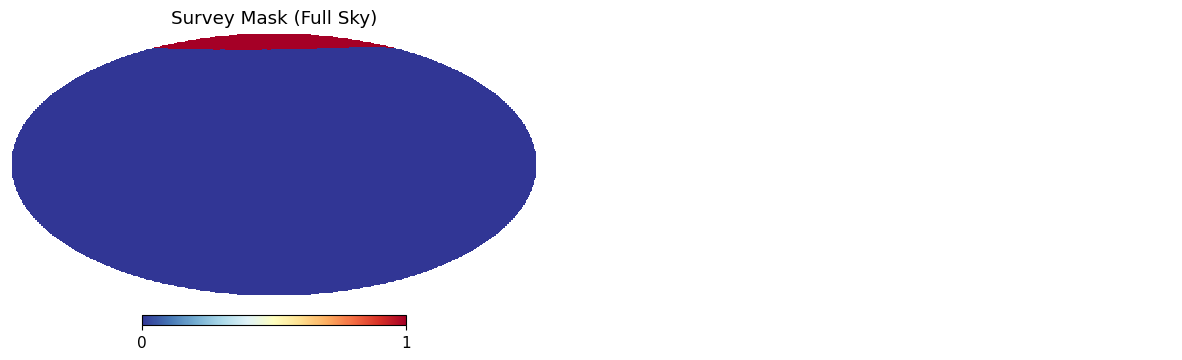

In [3]:
# Visualize the survey mask
fig = plt.figure(figsize=(15, 10))

# Full sky view
plt.subplot(2, 2, 1)
hp.mollview(mask, title="Survey Mask (Full Sky)", cbar=True, 
            cmap='RdYlBu_r', hold=True)

# Zoomed view around survey area
plt.subplot(2, 2, 2)
zoom_size = 30
hp.cartview(mask, 
            lonra=[survey_center_ra-zoom_size, survey_center_ra+zoom_size],
            latra=[survey_center_dec-zoom_size, survey_center_dec+zoom_size],
            title='Survey Mask (Zoomed)', cbar=True, hold=True)

# Show mask statistics
plt.subplot(2, 2, 3)
mask_values, mask_counts = np.unique(mask, return_counts=True)
plt.pie(mask_counts, labels=['Masked', 'Observed'], autopct='%1.1f%%', 
        colors=['lightcoral', 'skyblue'])
plt.title('Sky Coverage')

plt.tight_layout()
plt.show()

print(f"\n📊 Mask Statistics:")
print(f"  Observed fraction: {np.sum(mask)/len(mask)*100:.2f}%")
print(f"  Full sky area: {4*np.pi*(180/np.pi)**2:.0f} sq deg")
print(f"  Survey area: {actual_area:.0f} sq deg")

## Part 2: Setting Up GalSBI for Catalogue Generation

Now we'll set up GalSBI to generate galaxy catalogues within our survey mask. We'll create multiple sub-catalogues to cover the survey area efficiently.

### Understanding the Strategy

For large survey areas, it's often efficient to:
1. **Divide the survey** into smaller regions (sub-masks)
2. **Generate catalogues** for each region separately
3. **Combine results** to get the full survey catalogue

This approach is more memory-efficient and allows parallel processing.

In [4]:
# Set up parameters for catalogue generation
patch_pixels = np.where(mask > 0)[0]  # Pixels within survey area
n_pixels = int(np.sum(mask))          # Total observed pixels
pixels_per_mask = 50                  # Pixels per sub-catalogue

print(f"🔧 Catalogue Generation Setup:")
print(f"  Total observed pixels: {n_pixels:,}")
print(f"  Pixels per sub-catalogue: {pixels_per_mask}")
print(f"  Number of sub-catalogues needed: {n_pixels // pixels_per_mask + 1}")

# Create sub-masks for batch processing
submasks = []
catalog_names = []

for i in range(n_pixels // pixels_per_mask + 1):
    print(f"Creating sub-mask {i+1}/{n_pixels // pixels_per_mask + 1}")
    
    # Create empty mask
    submask = np.zeros(npix)
    
    # Select pixels for this batch
    start_idx = i * pixels_per_mask
    end_idx = min((i + 1) * pixels_per_mask, len(patch_pixels))
    pixels = patch_pixels[start_idx:end_idx]
    
    if len(pixels) > 0:  # Only create if there are pixels
        submask[pixels] = 1
        submasks.append(submask)
        catalog_names.append(f"catalog_batch_{i:03d}")

print(f"\n✅ Created {len(submasks)} sub-masks")
print(f"  Average pixels per sub-mask: {np.mean([np.sum(sm) for sm in submasks]):.1f}")

🔧 Catalogue Generation Setup:
  Total observed pixels: 18,823
  Pixels per sub-catalogue: 50
  Number of sub-catalogues needed: 377
Creating sub-mask 1/377
Creating sub-mask 2/377
Creating sub-mask 3/377
Creating sub-mask 4/377
Creating sub-mask 5/377
Creating sub-mask 6/377
Creating sub-mask 7/377
Creating sub-mask 8/377
Creating sub-mask 9/377
Creating sub-mask 10/377
Creating sub-mask 11/377
Creating sub-mask 12/377
Creating sub-mask 13/377
Creating sub-mask 14/377
Creating sub-mask 15/377
Creating sub-mask 16/377
Creating sub-mask 17/377
Creating sub-mask 18/377
Creating sub-mask 19/377
Creating sub-mask 20/377
Creating sub-mask 21/377
Creating sub-mask 22/377
Creating sub-mask 23/377
Creating sub-mask 24/377
Creating sub-mask 25/377
Creating sub-mask 26/377
Creating sub-mask 27/377
Creating sub-mask 28/377
Creating sub-mask 29/377
Creating sub-mask 30/377
Creating sub-mask 31/377
Creating sub-mask 32/377
Creating sub-mask 33/377
Creating sub-mask 34/377
Creating sub-mask 35/377
Cr

### GalSBI Catalogue Generation Function

Here's the function that would generate catalogues using GalSBI. Note that this requires the GalSBI package to be installed:

In [5]:
def process_healpix_submask(submask, catalog_name, model_name="Fischbacher+24", 
                           gals_mag_max=25, verbose=True):
    """
    Generate galaxy catalogue for a HEALPix sub-mask using GalSBI.
    
    Parameters:
    -----------
    submask : array
        HEALPix mask array (1 = observed, 0 = masked)
    catalog_name : str
        Name for the output catalogue
    model_name : str
        GalSBI model to use (default: "Fischbacher+24")
    gals_mag_max : float
        Maximum magnitude for galaxies (fainter = more galaxies)
    verbose : bool
        Print progress information
    
    Returns:
    --------
    catalog : structured array
        Generated galaxy catalogue
    """
    try:
        if verbose:
            observed_pixels = np.sum(submask)
            area_sqd = observed_pixels * hp.nside2pixarea(len(submask), degrees=True)
            print(f"  Processing {catalog_name}: {observed_pixels} pixels, {area_sqd:.1f} sq deg")
        
        # Initialize GalSBI model
        model = GalSBI(model_name)
        
        # Generate catalogue for this sub-mask
        model(healpix_map=submask, catalog_name=catalog_name, gals_mag_max=gals_mag_max)
        
        # Load the generated catalogue
        catalog = model.load_catalogs(combine=True)
        
        if verbose:
            print(f"  Generated {len(catalog)} galaxies")
        
        return catalog
    
    except Exception as e:
        print(f"  ❌ Error processing {catalog_name}: {e}")
        return None

print("📝 Catalogue generation function defined")
print("\n💡 Note: To actually generate catalogues, you need GalSBI installed.")
print("   For this tutorial, we'll work with the existing catalogue.npy file.")

📝 Catalogue generation function defined

💡 Note: To actually generate catalogues, you need GalSBI installed.
   For this tutorial, we'll work with the existing catalogue.npy file.


### Example Catalogue Generation Loop

Here's how you would generate catalogues for all sub-masks:

In [6]:
# Example catalogue generation (would require GalSBI)
def generate_full_survey_catalogue(submasks, catalog_names, 
                                 max_submasks=3, demo_mode=True):
    """
    Generate catalogues for multiple sub-masks.
    
    Parameters:
    -----------
    submasks : list
        List of HEALPix masks
    catalog_names : list
        List of catalogue names
    max_submasks : int
        Maximum number to process (for demo)
    demo_mode : bool
        If True, simulate without actually calling GalSBI
    """
    cats = []
    
    print(f"🔄 Starting catalogue generation for {min(len(submasks), max_submasks)} sub-masks...")
    
    for i in range(min(len(submasks), max_submasks)):
        print(f"\n📂 Processing sub-mask {i+1}/{min(len(submasks), max_submasks)}")
        
        if demo_mode:
            # Simulate processing time and results
            time.sleep(0.1)  # Simulate processing
            n_galaxies = int(np.sum(submasks[i]) * 100)  # ~100 galaxies per pixel
            print(f"  📊 [SIMULATED] Would generate ~{n_galaxies} galaxies")
            
        else:
            # Actual processing (requires GalSBI)
            tic = time.time()
            catalog = process_healpix_submask(submasks[i], catalog_names[i])
            toc = time.time()
            
            if catalog is not None:
                cats.append(catalog)
                print(f"  ⏱️ Time elapsed: {toc-tic:.1f} seconds")
    
    if demo_mode:
        print(f"\n🎯 Simulation complete! In real usage, this would generate")
        total_expected = sum(int(np.sum(sm) * 100) for sm in submasks[:max_submasks])
        print(f"   approximately {total_expected:,} galaxies across the survey area.")
    else:
        print(f"\n✅ Generated {len(cats)} catalogues with {sum(len(c) for c in cats):,} total galaxies")
    
    return cats

# Run demonstration
demo_cats = generate_full_survey_catalogue(submasks, catalog_names, 
                                         max_submasks=3, demo_mode=True)

🔄 Starting catalogue generation for 3 sub-masks...

📂 Processing sub-mask 1/3
  📊 [SIMULATED] Would generate ~5000 galaxies

📂 Processing sub-mask 2/3
  📊 [SIMULATED] Would generate ~5000 galaxies

📂 Processing sub-mask 3/3
  📊 [SIMULATED] Would generate ~5000 galaxies

🎯 Simulation complete! In real usage, this would generate
   approximately 15,000 galaxies across the survey area.


## Part 3: Working with Generated Catalogues

Let's examine the structure and properties of galaxy catalogues. We'll use the existing `catalogue.npy` file as an example:

In [7]:
# Load the example catalogue
try:
    catalogue = np.load("catalogue.npy", allow_pickle=True)
    print(f"📁 Loaded example catalogue with {len(catalogue):,} galaxies")
    
    # Examine catalogue structure
    print(f"\n🔍 Catalogue Properties:")
    print(f"  Data type: {type(catalogue)}")
    if hasattr(catalogue, 'dtype'):
        print(f"  Fields: {list(catalogue.dtype.names)}")
        
        # Show basic statistics for each field
        for field in catalogue.dtype.names:
            data = catalogue[field]
            if np.issubdtype(data.dtype, np.number):
                print(f"  {field}: [{data.min():.3f}, {data.max():.3f}], mean={data.mean():.3f}")
            else:
                print(f"  {field}: {type(data[0])} (non-numeric)")
    
except FileNotFoundError:
    print("❌ catalogue.npy not found. This would be generated by GalSBI.")
    catalogue = None

📁 Loaded example catalogue with 117,628 galaxies

🔍 Catalogue Properties:
  Data type: <class 'numpy.ndarray'>
  Fields: ['gamma1', 'int_e1', 'template_coeffs', 'z', 'dec', 'ra', 'excess_b_v', 'int_mag g', 'id', 'e1', 'mag g', 'abs_mag_lumfun', 'int_e2', 'int_r50', 'e2', 'sersic_n', 'gamma2', 'galaxy_type', 'r50', 'template_coeffs_abs', 'abs_mag g', 'kappa', 'e_abs', 'bkg_noise_amp g', 'int_mag r', 'mag r', 'abs_mag r', 'bkg_noise_amp r', 'int_mag i', 'mag i', 'abs_mag i', 'bkg_noise_amp i', 'int_mag z', 'mag z', 'abs_mag z', 'bkg_noise_amp z', 'int_mag y', 'mag y', 'abs_mag y', 'bkg_noise_amp y']
  gamma1: [0.000, 0.000], mean=0.000
  int_e1: [-0.976, 0.976], mean=-0.002
  template_coeffs: [0.000, 0.000], mean=0.000
  z: [0.011, 5.381], mean=2.061
  dec: [88.542, 89.997], mean=89.280
  ra: [0.003, 89.995], mean=45.026
  excess_b_v: [0.217, 0.569], mean=0.313
  int_mag g: [18.350, 30.444], mean=26.924
  id: [1.000, 339020.000], mean=175437.567
  e1: [-0.976, 0.976], mean=-0.002
  mag g

### Understanding Catalogue Fields

Typical galaxy catalogue fields include:

| Field | Description | Units |
|-------|-------------|-------|
| `ra` | Right Ascension | degrees |
| `dec` | Declination | degrees |
| `z` | Redshift | dimensionless |
| `r50` | Half-light radius | pixels or arcsec |
| `mag_*` | Magnitude in various bands | AB magnitude |
| `flux_*` | Flux in various bands | counts or Jy |
| `ellipticity` | Shape parameters | dimensionless |
| `snr` | Signal-to-noise ratio | dimensionless |

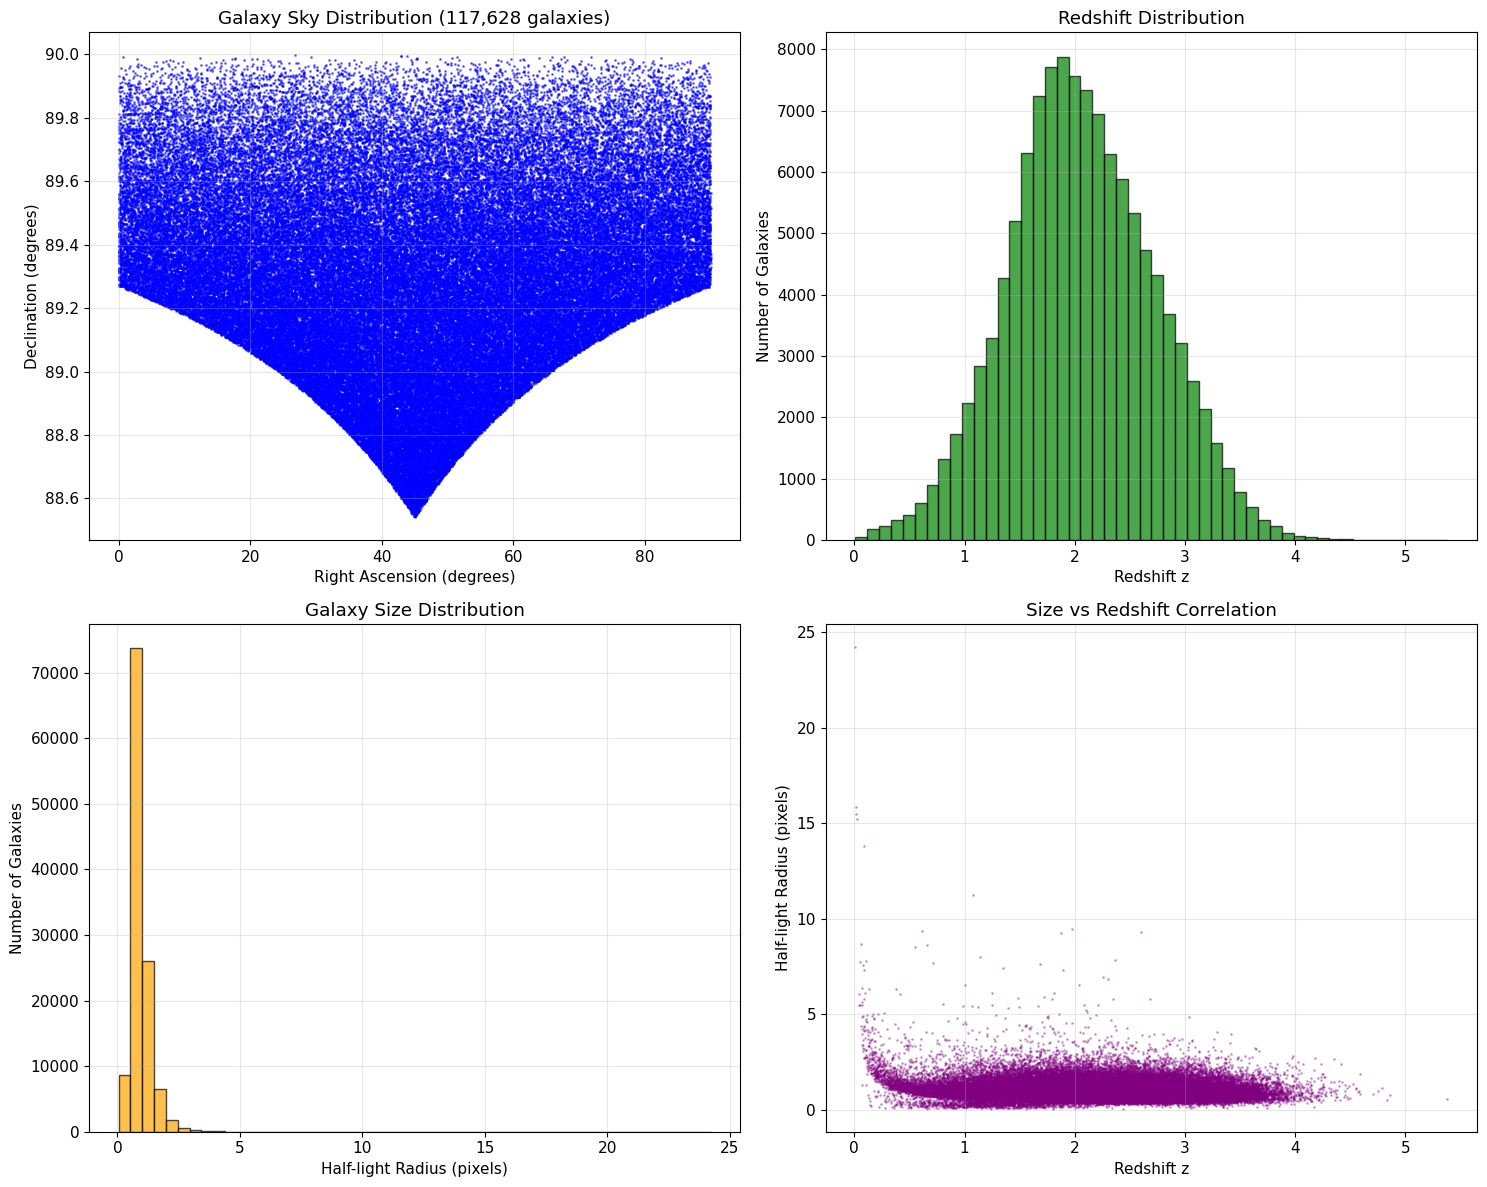


📊 Catalogue Summary:
  Total galaxies: 117,628
  Sky coverage: 89.99° × 1.46°
  Redshift range: 0.011 - 5.381
  Mean redshift: 2.061
  Size range: 0.049 - 24.210 pixels
  Mean size: 0.933 pixels


In [8]:
if catalogue is not None:
    # Detailed analysis of the catalogue
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Sky distribution
    ax1.scatter(catalogue['ra'], catalogue['dec'], s=1, alpha=0.5, c='blue')
    ax1.set_xlabel('Right Ascension (degrees)')
    ax1.set_ylabel('Declination (degrees)')
    ax1.set_title(f'Galaxy Sky Distribution ({len(catalogue):,} galaxies)')
    ax1.grid(True, alpha=0.3)
    
    # 2. Redshift distribution
    ax2.hist(catalogue['z'], bins=50, alpha=0.7, color='green', edgecolor='black')
    ax2.set_xlabel('Redshift z')
    ax2.set_ylabel('Number of Galaxies')
    ax2.set_title('Redshift Distribution')
    ax2.grid(True, alpha=0.3)
    
    # 3. Size distribution
    ax3.hist(catalogue['r50'], bins=50, alpha=0.7, color='orange', edgecolor='black')
    ax3.set_xlabel('Half-light Radius (pixels)')
    ax3.set_ylabel('Number of Galaxies')
    ax3.set_title('Galaxy Size Distribution')
    ax3.grid(True, alpha=0.3)
    
    # 4. Size vs redshift
    ax4.scatter(catalogue['z'], catalogue['r50'], s=1, alpha=0.3, c='purple')
    ax4.set_xlabel('Redshift z')
    ax4.set_ylabel('Half-light Radius (pixels)')
    ax4.set_title('Size vs Redshift Correlation')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\n📊 Catalogue Summary:")
    print(f"  Total galaxies: {len(catalogue):,}")
    print(f"  Sky coverage: {(catalogue['ra'].max() - catalogue['ra'].min()):.2f}° × {(catalogue['dec'].max() - catalogue['dec'].min()):.2f}°")
    print(f"  Redshift range: {catalogue['z'].min():.3f} - {catalogue['z'].max():.3f}")
    print(f"  Mean redshift: {catalogue['z'].mean():.3f}")
    print(f"  Size range: {catalogue['r50'].min():.3f} - {catalogue['r50'].max():.3f} pixels")
    print(f"  Mean size: {catalogue['r50'].mean():.3f} pixels")

else:
    print("🚧 Cannot analyze catalogue - file not available")

## Part 4: Quality Checks and Validation

When working with generated catalogues, it's important to validate that they meet expectations:

In [9]:
def validate_catalogue(catalogue, expected_area_sq_deg=None):
    """
    Perform quality checks on a galaxy catalogue.
    
    Parameters:
    -----------
    catalogue : structured array
        Galaxy catalogue to validate
    expected_area_sq_deg : float, optional
        Expected survey area in square degrees
    """
    print("🔍 CATALOGUE VALIDATION")
    print("=" * 40)
    
    # Basic checks
    n_galaxies = len(catalogue)
    print(f"✓ Number of galaxies: {n_galaxies:,}")
    
    # Coordinate checks
    ra_range = catalogue['ra'].max() - catalogue['ra'].min()
    dec_range = catalogue['dec'].max() - catalogue['dec'].min()
    area_sq_deg = ra_range * dec_range  # Approximate
    
    print(f"✓ RA range: {ra_range:.2f}°")
    print(f"✓ Dec range: {dec_range:.2f}°")
    print(f"✓ Approximate area: {area_sq_deg:.1f} sq deg")
    
    if expected_area_sq_deg:
        area_ratio = area_sq_deg / expected_area_sq_deg
        print(f"✓ Area ratio (actual/expected): {area_ratio:.2f}")
    
    # Galaxy density
    density = n_galaxies / area_sq_deg
    print(f"✓ Galaxy density: {density:.1f} galaxies/sq deg")
    
    # Redshift checks
    z_mean = catalogue['z'].mean()
    z_std = catalogue['z'].std()
    print(f"✓ Mean redshift: {z_mean:.3f} ± {z_std:.3f}")
    
    # Size checks
    size_mean = catalogue['r50'].mean()
    size_std = catalogue['r50'].std()
    print(f"✓ Mean size: {size_mean:.3f} ± {size_std:.3f} pixels")
    
    # Check for obvious problems
    warnings = []
    if np.any(catalogue['ra'] < 0) or np.any(catalogue['ra'] > 360):
        warnings.append("RA values outside [0, 360] range")
    if np.any(catalogue['dec'] < -90) or np.any(catalogue['dec'] > 90):
        warnings.append("Dec values outside [-90, 90] range")
    if np.any(catalogue['z'] < 0):
        warnings.append("Negative redshift values")
    if np.any(catalogue['r50'] <= 0):
        warnings.append("Non-positive size values")
    
    if warnings:
        print(f"\n⚠️  WARNINGS:")
        for warning in warnings:
            print(f"   • {warning}")
    else:
        print(f"\n✅ All basic validation checks passed!")

# Run validation on our example catalogue
if catalogue is not None:
    validate_catalogue(catalogue, expected_area_sq_deg=100)
else:
    print("🚧 Cannot validate - catalogue not available")

🔍 CATALOGUE VALIDATION
✓ Number of galaxies: 117,628
✓ RA range: 89.99°
✓ Dec range: 1.46°
✓ Approximate area: 131.0 sq deg
✓ Area ratio (actual/expected): 1.31
✓ Galaxy density: 898.1 galaxies/sq deg
✓ Mean redshift: 2.061 ± 0.663
✓ Mean size: 0.933 ± 0.431 pixels

✅ All basic validation checks passed!


## Part 5: Saving and Loading Catalogues

Best practices for catalogue management:

In [ ]:
def save_catalogue(catalogue, filename, metadata=None):
    """
    Save catalogue with metadata.
    
    Parameters:
    -----------
    catalogue : structured array
        Galaxy catalogue
    filename : str
        Output filename
    metadata : dict, optional
        Additional metadata to save
    """
    # Save the catalogue
    np.save(filename, catalogue)
    
    # Save metadata separately
    if metadata is None:
        metadata = {}
    
    # Add automatic metadata
    metadata.update({
        'n_galaxies': len(catalogue),
        'fields': list(catalogue.dtype.names),
        'ra_range': [float(catalogue['ra'].min()), float(catalogue['ra'].max())],
        'dec_range': [float(catalogue['dec'].min()), float(catalogue['dec'].max())],
        'z_range': [float(catalogue['z'].min()), float(catalogue['z'].max())],
        'creation_time': time.strftime('%Y-%m-%d %H:%M:%S')
    })
    
    # Save metadata as JSON
    import json
    metadata_file = filename.replace('.npy', '_metadata.json')
    with open(metadata_file, 'w') as f:
        json.dump(metadata, f, indent=2)
    
    print(f"💾 Saved catalogue: {filename}")
    print(f"💾 Saved metadata: {metadata_file}")

# Example usage (demonstration only)
if catalogue is not None:
    # Create example metadata
    demo_metadata = {
        'survey_name': 'Demo Survey',
        'galsbi_model': 'Fischbacher+24',
        'mag_limit': 25.0,
        'pixel_scale': 0.263,
        'notes': 'Generated for KappaBySizes tutorial'
    }
    
    print("📋 Example metadata structure:")
    import json
    print(json.dumps(demo_metadata, indent=2))
    
    # Note: Not actually saving to avoid modifying the repository
    print("\n💡 In practice, you would call:")
    print("   save_catalogue(catalogue, 'my_survey_catalogue.npy', demo_metadata)")

else:
    print("🚧 Cannot demonstrate saving - catalogue not available")

## Summary and Next Steps

### What We've Learned

1. **Survey Masks**: How to create and work with HEALPix survey masks
2. **GalSBI Setup**: How to configure GalSBI for catalogue generation
3. **Batch Processing**: Strategies for generating large catalogues efficiently
4. **Catalogue Structure**: Understanding the fields and properties in galaxy catalogues
5. **Quality Control**: How to validate generated catalogues
6. **Data Management**: Best practices for saving and loading catalogues

### Key Concepts

- **Survey masks** define where observations are made
- **Galaxy catalogues** contain positions, redshifts, sizes, and other properties
- **Batch processing** enables efficient generation of large catalogues
- **Quality validation** ensures catalogues meet expectations
- **Metadata** is crucial for reproducible science

### Next Tutorial Preview

In **Tutorial 3: Redshift Distributions**, you will learn:
- How to extract and model redshift distributions from catalogues
- Using Gaussian Mixture Models for redshift binning
- Understanding the relationship between redshift and lensing efficiency
- Preparing redshift distributions for cosmological analysis

In [ ]:
# Tutorial completion summary
print("📋 TUTORIAL 2 COMPLETED")
print("=" * 40)
print("✅ Understanding survey masks and sky coverage")
print("✅ Setting up GalSBI for catalogue generation")
print("✅ Working with batch processing strategies")
print("✅ Analyzing catalogue structure and properties")
print("✅ Implementing quality validation procedures")
print("✅ Learning data management best practices")
print("\n🚀 Ready for Tutorial 3: Redshift Distributions and Cosmology")

if catalogue is not None:
    print(f"\n📊 Your catalogue: {len(catalogue):,} galaxies ready for analysis!")
else:
    print(f"\n💡 To generate your own catalogues, install GalSBI and run the generation code.")